In [1]:
%load_ext autoreload
%autoreload 2

# imports


In [3]:
from collections import namedtuple
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background, astro_flux
from aeff_calculations import calc_aeff_factor
from settings import ngc1068, BASEPATH
from tools import get_mids
from scipy.interpolate import RegularGridInterpolator
from os.path import join
from glob import glob


In [4]:

matplotlib = sns.mpl
plt = matplotlib.pyplot
warnings.filterwarnings("ignore")

plt.style.use(join(BASEPATH, "style.mplstyle"))
# get the savepath, which might be a local folder not in the repo
savepath = "/".join(glob(BASEPATH + "/*/fisher_casc.pickle")[0].split("/")[:-1])

# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle(join(savepath, "aeff_cluster_nuecc_with-eq.pickle"))


## binning

In [4]:
aeff_test = aeffs.iloc[0]["equatorial_fine"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

90 log_10(energy) bins
100 declination bins


# background

In [5]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), bg_flux_def = pickle.load(f)
# load total nue+nuebar + nutau+nutaubar
# (nutau+nutaubar is practically zero)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(bg_flux_def["nue_total"] + bg_flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

# astro flux source parameters

In [6]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# diffuse flux
from aeff_calculations import aeff_eval_e_sd
from settings import E_NORM, PHI_ASTRO, GAMMA_ASTRO
PHI_ASTRO *= 2 # two flavors (nue + nutau equal mixing)

print(PHI_ASTRO)
print(GAMMA_ASTRO)


2.88e-18
2.37


In [7]:
diff_config = {
    "diff_or_ps": "diff",
    "sindec_width": sindec_width,
    "ewidth": ewidth,
    "livetime": LIVETIME

}

# Flux definition

In [8]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}
flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")


## calculate number of events for diffuse flux

In [9]:
if False:
    # n_events = pd.read_pickle(join(savepath, "casc_events_diffuse.pickle"))
    n_events = []
    for ind, row in aeffs.iterrows():
        dct = {}
        for nm, val in zip(aeffs.index.names, ind):
            dct[nm] = val
        aeff_factor = (row["equatorial_fine"] * sindec_width).T * ewidth * 2 * np.pi * LIVETIME
        k_s = astro_flux(
            aeff_factor,
            emids,
            normed_kvals=None,
            phi_scaling=1,
            flux_shape=flux_def,
        )
        dct["n_sig"] = np.sum(k_s)

        k_b = atmo_background(
            aeff_factor,
            spl_vals,
        )
        dct["n_bg"] = np.sum(k_b)
        dct["s/sqb"] = dct["n_sig"] / np.sqrt(dct["n_bg"])
        n_events.append(dct)
    n_events = pd.DataFrame(n_events)

    pd.to_pickle(n_events, join(savepath, "casc_events_diffuse.pickle"))

    ax = sns.scatterplot(
        data=n_events, x="module_threshold", y="n_bg", hue="hit_threshold", palette="crest"
    )

    ax = sns.scatterplot(
        data=n_events, 
        x="module_threshold",
        y="n_sig",
        hue="hit_threshold",
        palette="crest",
    )


# simple diffuse fit

## energy and sindec resolution

In [9]:
resolution_df = pd.read_pickle(
    join(savepath, "optimization_resolutions_energy.pickle")
)
resolution_df = resolution_df.set_index(["config", "spacing", "pmts"])


## llh definition

In [10]:
def diffuse_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    spl_vals=spl_vals,
    plot_this=False,
    ereco=None, #only for plotting
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        spl_vals,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    mu_i = mu_s + mu_b
    if plot_this:
        print(np.shape(ereco), np.shape(mu_s), np.shape(mu_s.sum(axis=0)))
        f, axes = plt.subplots(ncols=2, figsize=(12, 6))
        axes[0].plot(
            ereco, mu_s.sum(axis=0), ls="-", label="mu_s", ds="steps-mid"
        )
        axes[0].plot(
            ereco, mu_b.sum(axis=0), ls="--", label="mu_b", ds="steps-mid"
        )
        axes[0].set_yscale("log")
        axes[0].legend()
        axes[0].set_title("ereco from llh function")

        sdm = np.linspace(-1, 1, len(mu_s))
        axes[1].plot(sdm, mu_s.sum(axis=1), ls="-", label="mu_s", ds="steps-mid")
        axes[1].plot(sdm, mu_b.sum(axis=1), ls="--", label="mu_b", ds="steps-mid")
        axes[1].set_title("sindec from llh function")

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# diffuse vs uniform atmospheric

## checks with plotting

In [12]:
if False:
    c_names = np.asarray(aeffs.index.names)
    mask = aeffs.index.get_level_values("spacing") >= 50

    atmo_range = np.linspace(0.1, 1.5, num=50)
    astro_range = np.linspace(0.1, 1.5, num=50)
    gamma_range = np.linspace(1, 4, num=20)

    diff_significances = []
    for full_det in [True, False]:
        for config, aeff in aeffs.loc[mask].iterrows():
            if full_det:
                aeff *= 7  # full detector
            aeff_test = aeff["equatorial_fine"]
            reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
            aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
            k_s = astro_flux(
                aeff_factor,
                emids,
                normed_kvals=reso_test.energy_res,
                phi_scaling=1,
                flux_shape=flux_def,
            )
            k_b = atmo_background(
                aeff_factor,
                spl_vals,
                normed_kvals=reso_test.energy_res,
            )

            k_i = k_s + k_b

            # fix signal contribution to 0
            fit_config = dict(
                mu_b_base=aeff_factor,
                mu_s_base=aeff_factor,
                k_i=k_i,
                e_0=E_NORM,
                phi_0=PHI_ASTRO,
                shape="powerlaw",
                normed_kvals=reso_test.energy_res,
            )
            local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
            global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                bounds=[(1e-3, 1e2)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, GAMMA_ASTRO),
                bounds=[(1e-3, 1e2), (1e-3, 1e2), (2.0, 3.0)],
                approx_grad=True,
                factr=10,
            )

            if True: 
                print("out comb", out_comp)
                print("out bg", out_bckg)

                # show llh space
                plt.figure()
                plt.title("local atmo vs TS")
                for ar in atmo_range:
                    check_bg = local_llh((ar,))
                    plt.scatter(ar, check_bg)
                plt.axvline(out_bckg[0][0], label="fit")
                plt.legend()

                plt.figure()
                plt.title("global astro vs TS")
                for ar in astro_range:
                    check = global_llh((1, ar, GAMMA_ASTRO))
                    plt.scatter(ar, check)
                plt.axvline(out_comp[0][1], label="fit")
                plt.axvline(1, label="truth", ls="--")
                plt.legend()

                # plot the fit result using the llh function
                diffuse_llh_2d_composite(
                    (out_bckg[0][0], 0, 2),
                    **fit_config,
                    plot_this=True,
                    ereco=get_mids(reso_test.ereco_bins)
                )
                diffuse_llh_2d_composite(
                    out_comp[0],
                    **fit_config,
                    plot_this=True,
                    ereco=get_mids(reso_test.ereco_bins)
                )

                # cross-check with manual plotting
                res_s = astro_flux(
                    aeff_factor,
                    emids,
                    normed_kvals=reso_test.energy_res,
                    phi_scaling=1,
                    flux_shape=PL_flux(
                        out_comp[0][1]*PHI_ASTRO, out_comp[0][2], E_NORM, "powerlaw"
                    ),
                )
                res_b = k_b * out_comp[0][0]
                res_b_0 = k_b * out_bckg[0][0]
                print(config)

                # show plots of fit results as check
                f, axes = plt.subplots(ncols=2, figsize=(12, 6))
                axes[0].plot(
                    get_mids(reso_test.ereco_bins),
                    k_s.sum(axis=0),
                    ls="-",
                    label="ks",
                    ds="steps-mid",
                )
                axes[0].plot(
                    get_mids(reso_test.ereco_bins),
                    k_b.sum(axis=0),
                    ls="-",
                    label="kb",
                    ds="steps-mid",
                )
                axes[0].plot(
                    get_mids(reso_test.ereco_bins),
                    res_b.sum(axis=0),
                    ls="--",
                    label="resb",
                    ds="steps-mid",
                )
                axes[0].plot(
                    get_mids(reso_test.ereco_bins),
                    res_s.sum(axis=0),
                    ls="--",
                    label="ress",
                    ds="steps-mid",
                )
                axes[0].plot(
                    get_mids(reso_test.ereco_bins),
                    res_b_0.sum(axis=0),
                    ls=":",
                    label="resb0",
                    ds="steps-mid",
                )
                axes[0].set_yscale("log")
                axes[0].legend()
                axes[0].set_title("fit result ereco")

                axes[1].plot(sindec_mids, k_s.sum(axis=1), ls="-", label="ks", ds="steps-mid")
                axes[1].plot(sindec_mids, k_b.sum(axis=1), ls="-", label="kb", ds="steps-mid")
                axes[1].plot(
                    sindec_mids, res_b.sum(axis=1), ls="--", label="resb", ds="steps-mid"
                )
                axes[1].plot(
                    sindec_mids, res_s.sum(axis=1), ls="--", label="ress", ds="steps-mid"
                )
                axes[1].plot(
                    sindec_mids, res_b_0.sum(axis=1), ls=":", label="resb0", ds="steps-mid"
                )
                axes[1].set_title("fit result sindec")

                plt.title(config)
                print("")
                plt.show()
                break
                #raise BaseException(">:O")
        break

## fitting

In [11]:
from itertools import product


In [34]:
c_names = np.asarray(aeffs.index.names)
mask = aeffs.index.get_level_values("spacing") >= 50
# flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")
gammas = [2, 2.37, 3]
for gamma, full_det in product(gammas, [False, True]):
    flux_def = PL_flux(1E-18, gamma, E_NORM, "powerlaw")

    diff_significances = []
    for config, aeff in aeffs.loc[mask].iterrows():
        if full_det:
            aeff *= 7  # full detector
        tmp = {key: val for key, val in zip(c_names, config)}
        aeff_test = aeff["equatorial_fine"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
        k_s = astro_flux(
            aeff_factor,
            emids,
            normed_kvals=reso_test.energy_res,
            phi_scaling=1,
            flux_shape=flux_def,
        )

        k_b = atmo_background(
            aeff_factor,
            spl_vals,
            normed_kvals=reso_test.energy_res,
        )

        mu_base = np.copy(aeff_factor)
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)

        fit_config = dict(
            mu_b_base=aeff_factor,
            mu_s_base=aeff_factor,
            k_i=k_i,
            e_0=flux_def.E0,
            phi_0=flux_def.norm,
            shape="powerlaw",
            normed_kvals=reso_test.energy_res,
        )
        # fix signal contribution to 0
        local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
        global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.1,),
            bounds=[(1e-3, 1e2)],
            approx_grad=True,
        )
        tmp["bg_atmo_norm"] = out_bckg[0][0]

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.0, 1.0, 2.3),
            bounds=[(1e-3, 1e2), (1e-3, 1e2), (1.5, 3.5)],
            approx_grad=True,
            factr=10,
        )
        # tmp["status"] = out_comp[2]["warnflag"]
        # tmp["comb_atmo_norm"] = out_comp[0][0]
        # tmp["comb_astro_norm"] = out_comp[0][1]
        # tmp["comb_astro_gamma"] = out_comp[0][2]
        # tmp["-2DLLH"] = out_bckg[1] - out_comp[1]
        # tmp["bg_TS"] = out_bckg[1]
        # tmp["comb_TS"] = out_comp[1]
        tmp["check_TS"] = global_llh((1, 1, GAMMA_ASTRO))

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        tmp["check_sigma"] = erfinv(
            1 - chi2.sf(out_bckg[1] - tmp["check_TS"], 2)
        ) * np.sqrt(2)
        diff_significances.append(tmp)

    diff_significances = pd.DataFrame(diff_significances)
    add = "full" if full_det else "cluster"
    pd.to_pickle(
        diff_significances,
        join(savepath, f"casc_diffuse_significance_{add}_gamma-{flux_def.gamma}.pckl"),
    )


## plotting

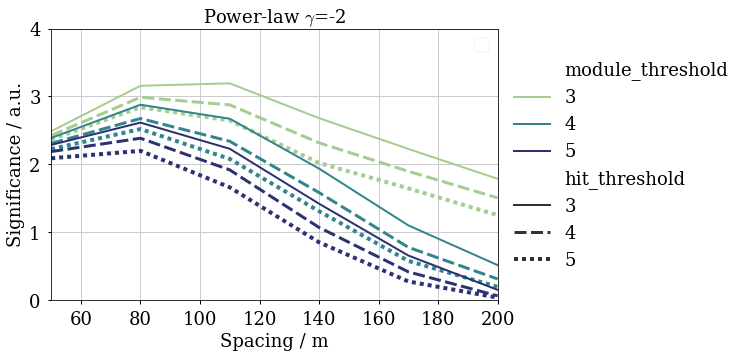

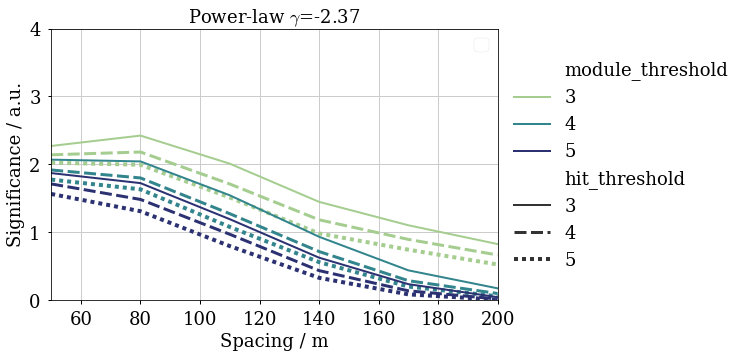

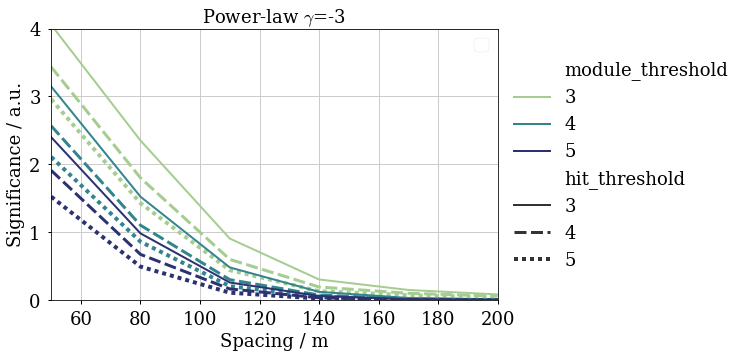

In [35]:
gammas = [2, 2.37, 3]
for gamma in gammas:
    diff_significances_cluster = pd.read_pickle(
        join(savepath, f"casc_diffuse_significance_cluster_gamma-{gamma}.pckl")
    )

    selection = diff_significances_cluster.loc[
        (diff_significances_cluster.hit_threshold >= 3)
        & (diff_significances_cluster.module_threshold >= 3)
    ]

    f, ax = plt.subplots(figsize=(8, 5))
    ncols = len(selection.module_threshold.unique())

    condition = (
        selection.min_pos_resolution == 2
        # selection.min_pos_resolution.isna()
        # & (selection.hit_threshold == 3)
    )

    ax = sns.lineplot(
        data=selection.loc[condition],
        y="sigma",
        x="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        palette="crest",
        ax=ax,
        sizes=(2, 4),
        #lw=2,
        #s=150,
    )
    lg = f.legend(
        ncol=1,
        loc="center left",
        bbox_to_anchor=(0.9, 0.5),
        frameon=False,
    )
    ax.legend([])
    for lh in lg.legendHandles:
        lh._sizes = [150]
    # lg.set_title("Module Threshold")
    # title = lg.get_title()
    # title.set_fontsize(18)

    ax.set_ylabel(r"Significance / a.u.")
    ax.set_ylim(0, 4)
    ax.set_xlim(50, 200)
    ax.set_xlabel("Spacing / m")
    ax.set_title(rf"Power-law $\gamma$=-{gamma}")

    # f.tight_layout()
    # f.savefig(join(BASEPATH, "plots/cascades_diff_significances.png"))


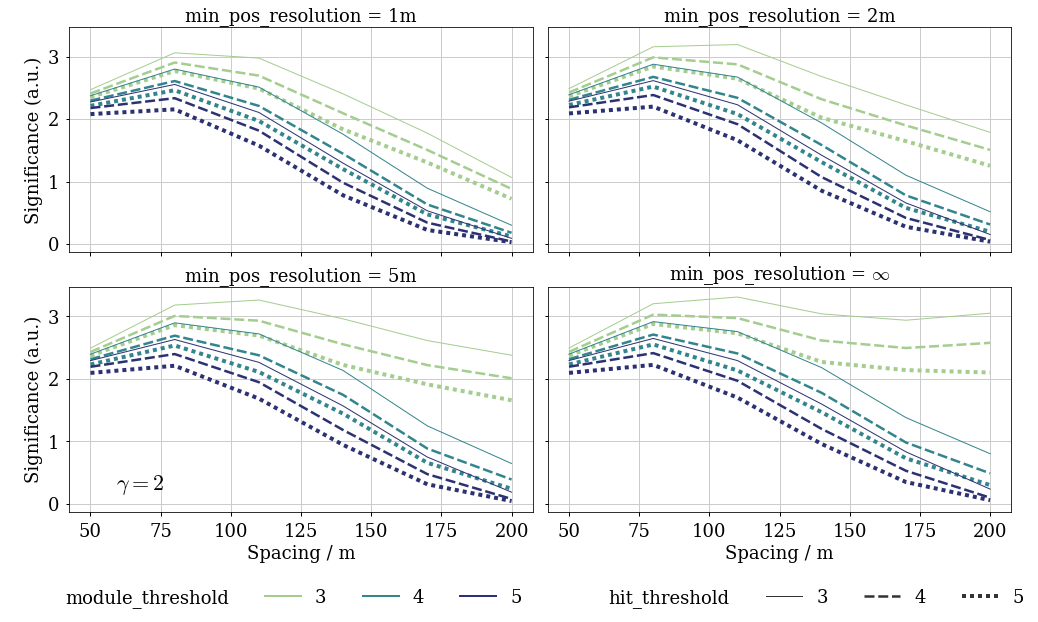

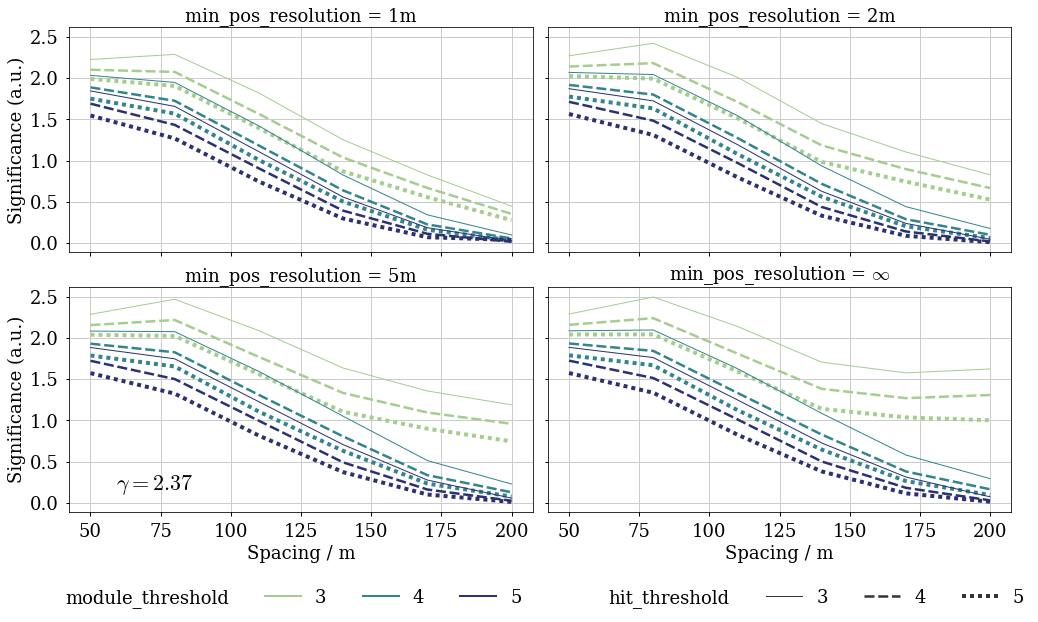

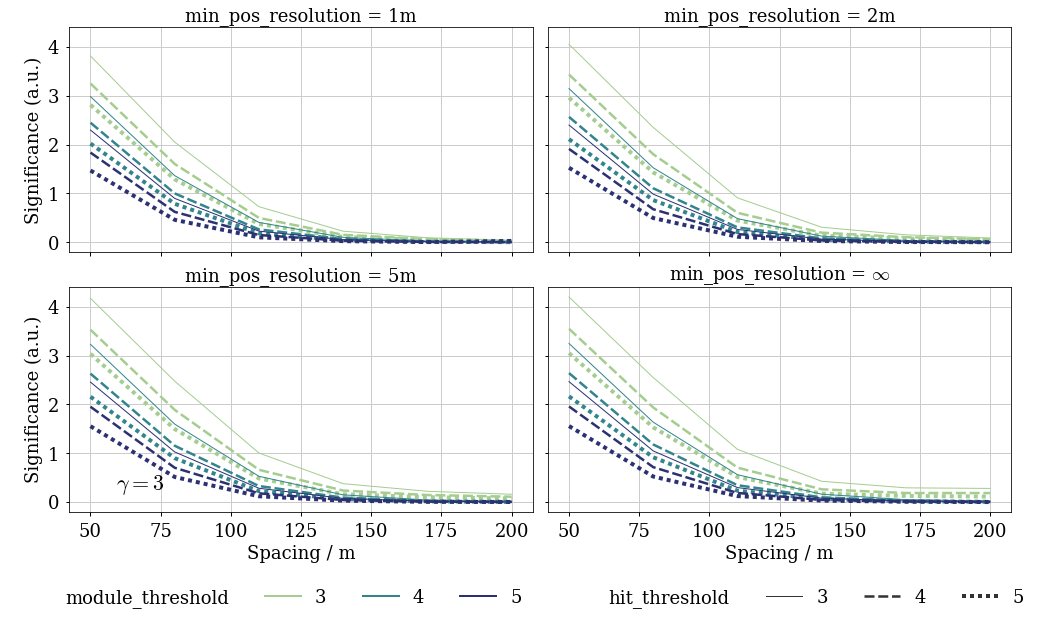

In [36]:
gammas = [2, 2.37, 3]
for gamma in gammas:
    diff_significances_cluster = pd.read_pickle(
        join(savepath, f"casc_diffuse_significance_cluster_gamma-{gamma}.pckl")
    )

    selection = diff_significances_cluster.loc[
        (diff_significances_cluster.hit_threshold >= 3)
        & (diff_significances_cluster.module_threshold >= 3)
    ]
    f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
    ncols = len(selection.module_threshold.unique())

    condition = [
        ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
        ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
        ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
        (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
    ]


    for ii, ax in enumerate(axes.flatten()):

        # ax = sns.scatterplot(
        ax = sns.lineplot(
            data=selection.loc[condition[ii][1]],
            y="sigma",
            x="spacing",
            hue="module_threshold",
            style="hit_threshold",
            size="hit_threshold",
            #sizes=(100, 200),
            palette="crest",
            ax=ax,
        )
        #ax.set_xscale("log")
        ax.set_title(condition[ii][0])

        if ii==0:
            lg = f.legend(
            ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18
        )
        ax.legend([], frameon=False)
        for lh in lg.legendHandles:
            lh._sizes = [150]

    axes[0][0].set_ylabel("Significance (a.u.)")
    axes[1][0].set_xlabel("Spacing / m")
    axes[1][1].set_xlabel("Spacing / m")
    axes[1][0].set_ylabel("Significance (a.u.)")
    f.text(0.1, 0.1, rf"$\gamma={gamma}$", transform=axes[1][0].transAxes, fontsize=22)
    f.tight_layout()
    f.savefig(join(BASEPATH, f"plots/cascades_diff_significances_gamma-{gamma}.png"))
    #break


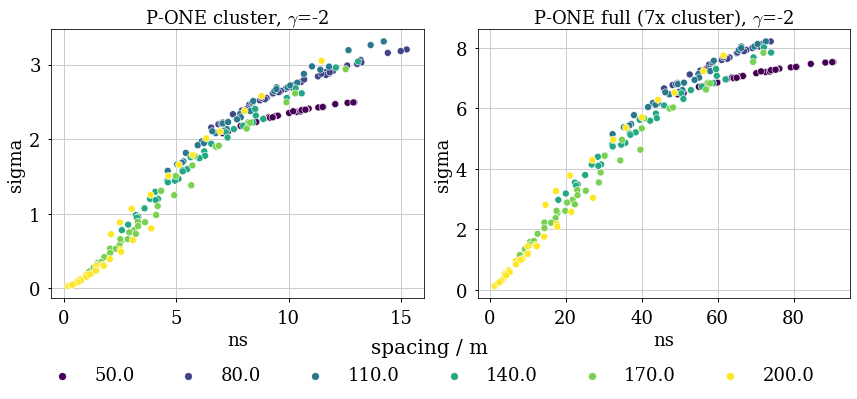

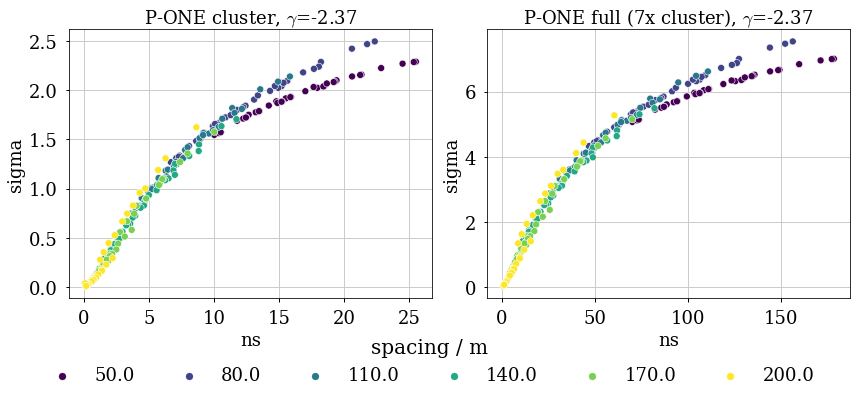

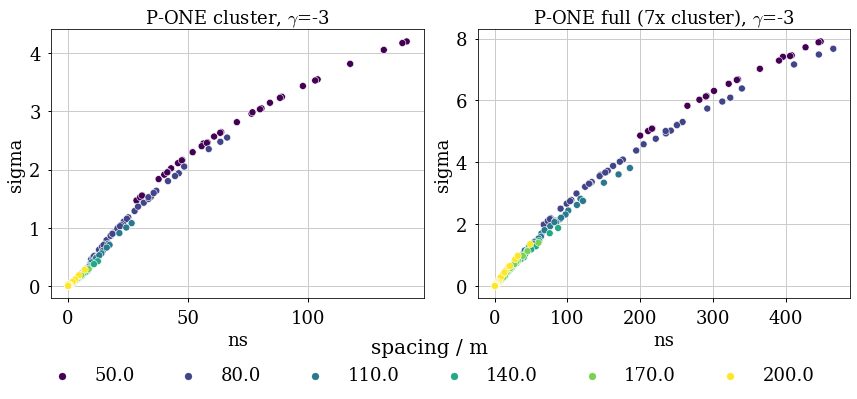

In [37]:
for gamma in gammas:
    diff_significances_cluster = pd.read_pickle(
            join(savepath, f"casc_diffuse_significance_cluster_gamma-{gamma}.pckl")
        )
    diff_significances_full = pd.read_pickle(
            join(savepath, f"casc_diffuse_significance_full_gamma-{gamma}.pckl")
        )
    f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))
    ax = sns.scatterplot(
        data=diff_significances_cluster.loc[
            (diff_significances_cluster.hit_threshold >= 3)
            & (diff_significances_cluster.module_threshold >= 3)
        ],
        x="ns",
        y="sigma",
        hue="spacing",
        palette="viridis",
        ax=ax1,
    )
    ax.set_title(fr"P-ONE cluster, $\gamma$=-{gamma}")
    legend = f.legend(
        ncol=6,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.1),
        title="spacing / m",
        frameon=False,
    )
    legend.get_title().set_fontsize(20)
    ax.legend([], frameon=False)
    ax = sns.scatterplot(
        data=diff_significances_full.loc[
            (diff_significances_full.hit_threshold >= 3)
            & (diff_significances_full.module_threshold >= 3)
        ],
        x="ns",
        y="sigma",
        hue="spacing",
        palette="viridis",
        ax=ax2,
    )
    ax.set_title(fr"P-ONE full (7x cluster), $\gamma$=-{gamma}")
    ax.legend([], frameon=False)

    plt.tight_layout()


# Discovery potential

In [81]:
c_names = np.asarray(aeffs.index.names)
aeff_selection_mask = (
    (aeffs.index.get_level_values("module_threshold") >= 3)
    & (aeffs.index.get_level_values("hit_threshold") == 3)
    & (aeffs.index.get_level_values("spacing") >= 50)
    & (aeffs.index.get_level_values("min_pos_resolution")>=1)
)
gammas = [2, 2.37, 3]
num = 15
flux_scalings = {
    2: np.logspace(-0.5, 2.2, num=num),
    2.37: np.logspace(-0.5, 2.5, num=num),
    3: np.logspace(-0.5, 3.5, num=num),
}
add = "cluster"
diff_significances = []

for gamma in gammas:
    
    for flux_scale, (config, aeff) in product(
        flux_scalings[gamma], aeffs.loc[aeff_selection_mask].iterrows()
    ):
        tmp = {key: val for key, val in zip(c_names, config)}
        flux_def = PL_flux(1e-18 * flux_scale, gamma, E_NORM, "powerlaw")
        aeff_test = aeff["equatorial_fine"]
        reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
        aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
        k_s = astro_flux(
            aeff_factor,
            emids,
            normed_kvals=reso_test.energy_res,
            phi_scaling=1,
            flux_shape=flux_def,
        )

        k_b = atmo_background(
            aeff_factor,
            spl_vals,
            normed_kvals=reso_test.energy_res,
        )

        mu_base = np.copy(aeff_factor)
        k_i = k_s + k_b

        tmp["nb"] = np.sum(k_b)
        tmp["ns"] = np.sum(k_s)
        tmp["flux_scale"] = flux_scale
        tmp["gamma"] = gamma

        fit_config = dict(
            mu_b_base=aeff_factor,
            mu_s_base=aeff_factor,
            k_i=k_i,
            e_0=flux_def.E0,
            phi_0=flux_def.norm,
            shape="powerlaw",
            normed_kvals=reso_test.energy_res,
        )
        # fix signal contribution to 0
        local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
        global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
        out_bckg = fmin_l_bfgs_b(
            local_llh,
            x0=(1.1,),
            bounds=[(1e-3, 1e5)],
            approx_grad=True,
        )

        out_comp = fmin_l_bfgs_b(
            global_llh,
            x0=(1.0, 1.0, 2.3),
            bounds=[(1e-3, 1e5), (1e-3, 1e5), (1.0, 4.5)],
            approx_grad=True,
            factr=10,
        )

        pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
        significance = erfinv(1 - pval) * np.sqrt(2)
        tmp["pval"] = pval
        tmp["sigma"] = significance
        diff_significances.append(tmp)

diff_significances = pd.DataFrame(diff_significances)
pd.to_pickle(
    diff_significances,
    join(savepath, f"casc_diffuse_significance_{add}_DP.pckl"),
)



Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.

Intel MKL ERROR: Parameter 4 was incorrect on entry to DGELSD.


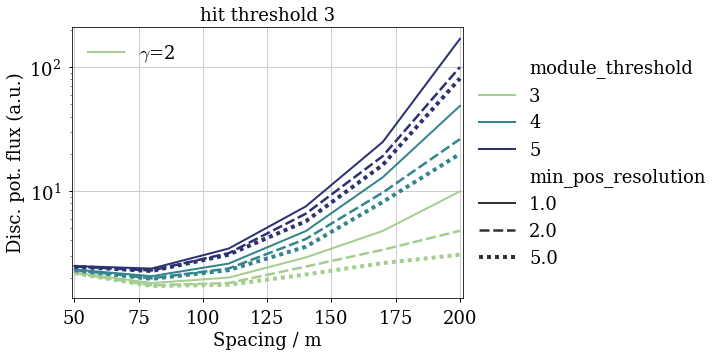

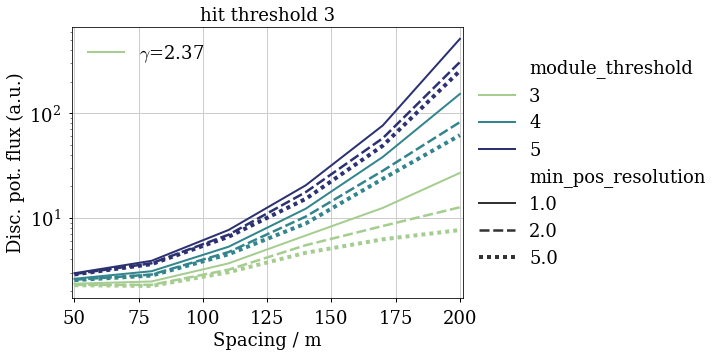

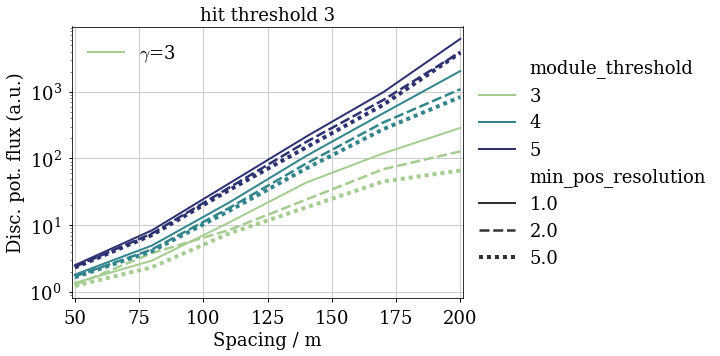

In [90]:
gb_names = ["hit_threshold", "module_threshold", "spacing", "min_pos_resolution"]
diff_dp = pd.read_pickle(
    join(
        savepath,
        f"casc_diffuse_significance_{add}_DP.pckl",
    )
)
for gamma in gammas:

    selection = diff_dp.loc[diff_dp.gamma == gamma]
    DPs = []
    for config, series in selection.groupby(gb_names):
        mask = np.isfinite(series.sigma)
        try:
            func_inv = np.poly1d(
                np.polyfit(
                    np.log10(series[mask].sigma),
                    np.log10(series[mask].flux_scale),
                    2,
                )
            )

            sigma5_DP = 10 ** func_inv(np.log10(5))
        except:
            sigma5_DP = np.nan
        # plt.figure(1)
        # plt.plot(
        #     np.log10(series[mask].sigma),
        #     np.log10(series[mask].flux_scale),
        # )
        tmp = {key: val for key, val in zip(gb_names, config)}
        tmp["DP_flux"] = sigma5_DP
        DPs.append(tmp)
    DPs = pd.DataFrame(DPs)

    hts = DPs.hit_threshold.unique()
    f, axes = plt.subplots(ncols=len(hts), figsize=(7 * len(hts), 5))

    for ii, ht in enumerate(hts):
        condition = DPs.hit_threshold == ht
        ax = sns.lineplot(
            data=DPs.loc[condition],
            y="DP_flux",
            x="spacing",
            hue="module_threshold",
            palette="crest",
            style="min_pos_resolution",
            size="min_pos_resolution",
            sizes=(2, 4),
            ax=axes[ii] if len(hts) > 1 else axes,
        )
        ax.set_title(f"hit threshold {ht}")
        ax.set_ylabel("Disc. pot. flux (a.u.)")
        ax.set_xlabel("Spacing / m")
        if ii == 0:
            lg = f.legend(
                ncol=1,
                loc="center left",
                bbox_to_anchor=(0.9, 0.5),
                frameon=False,
            )
        alg = ax.legend([rf"$\gamma$={gamma}"], frameon=0)
        ax.set_xlim(49, 201)
        # ax.set_ylim(1E1, 1E4)
        ax.semilogy()
    # break
